In [61]:

import seaborn as sns
import pandas as pd
import numpy as np
import math

import os

import matplotlib.pyplot as plt

def eakf_step(x_prior, params_prior, obs_ens_time, obs_time, oev_time, dict_params_range, num_var=8):

    prior_mean_ct = obs_ens_time.mean()
    prior_var_ct  = obs_ens_time.var()

    if prior_mean_ct == 0:
        post_var_ct  = 1e-3
        prior_var_ct = 1e-3

    post_var_ct  = prior_var_ct * oev_time / (prior_var_ct + oev_time)
    post_mean_ct = post_var_ct * (prior_mean_ct/prior_var_ct + obs_time / oev_time)
    alpha        = oev_time / (oev_time+prior_var_ct); alpha = alpha**0.5
    dy           = post_mean_ct + alpha*( obs_ens_time - prior_mean_ct ) - obs_ens_time

    # adjust parameters
    rr = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        A = np.cov(params_prior[idx_p,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr         = np.array(rr)
    dx         = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    param_post = params_prior + dx

    # adjust variables
    rr = []
    for idx_var in range(num_var):
        A = np.cov(x_prior[idx_var,:], obs_ens_time)
        rr.append( A[1,0] / prior_var_ct )

    rr       = np.array(rr)
    dx       = np.dot( np.expand_dims(rr,-1), np.expand_dims(dy, 0) )
    x_post   = x_prior + dx

    obs_post    = obs_ens_time + dy

    return x_post, param_post, obs_post

def checkbound_params_old(dict_params_range, params_ens, num_ensembles=300):

    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]
        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]


        p_ens[idx_wrong] = np.median(p_ens[idx_good])
        params_update.append(p_ens)

        print(f"{p}: {np.median(p_ens)}")

    return np.array(params_update)

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop, num_params=8, num_ensembles=300):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, 0, upp)
    return x_state_ens

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))

from scipy.stats import truncnorm
import numpy as np


def sample_params_uniform(dict_params_range, num_ensembles=100):
    param_ens_prior = []
    for p in dict_params_range.keys():
        param_ens_prior.append( np.random.uniform( dict_params_range[p][0], dict_params_range[p][1]  , size=num_ensembles) )
    return np.array( param_ens_prior )

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

def create_df_response(samples, time, date_init ='2020-03-06',  quantiles = [50, 80, 95], forecast_horizon=27, dates=None, use_future=False):
    """[summary]

    Args:
        samples ([type]): [description]
        time ([type]): [description]
        date_init (str, optional): [description]. Defaults to '2020-03-06'.
        forecast_horizon (int, optional): [description]. Defaults to 27.
        use_future (bool, optional): [description]. Defaults to False.

    Returns:
        [type]: [description]
    """
    if dates is not None:
        dates_fitted = dates
    else:
        dates_fitted   = pd.date_range(start=pd.to_datetime(date_init), periods=time)
        dates_forecast = pd.date_range(start=dates_fitted[-1]+datetime.timedelta(1), periods=forecast_horizon)

    dates = list(dates_fitted)
    types = ['estimate']*len(dates_fitted)
    if use_future:
        dates += list(dates_forecast)
        types  += ['forecast']*len(dates_forecast)

    results_df = pd.DataFrame(samples.T)
    df_response = pd.DataFrame(index=dates)
    # Calculate key statistics
    df_response['mean']        = results_df.mean(axis=1).values
    df_response['median']      = results_df.median(axis=1).values
    df_response['std']         = results_df.std(axis=1).values

    for quant in quantiles:
        low_q  = ((100-quant)/2)/100
        high_q = 1-low_q

        df_response[f'low_{quant}']  = results_df.quantile(q=low_q, axis=1).values
        df_response[f'high_{quant}'] = results_df.quantile(q=high_q, axis=1).values

    df_response['type']        =  types
    df_response.index.name = 'date'

    return df_response


In [70]:
def b_transition(var, rate, dt=1):
    kb        = np.maximum(1.0 - math.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(var, kb )

    return num_ind

def model(x, beta_i, beta_w, zeta, N):

    S   = x[0]   # Susceptibles
    I   = x[1]   # Infected Reported
    W   = x[2]   # Environmental Variable
    R   = x[3]   # Recovered

    gamma =  1/4

    foi1   =  beta_i * I / N
    foi2    = beta_w * W / N

    # Stochastic transitions
    s2i1     =  b_transition(S, foi1)                 # susceptible to exposed
    s2i2     =  b_transition(S, foi2)                 # susceptible to exposed

    i2r     =  b_transition(I, gamma) # exposed to infected reported who are not going to die
    w2o     =  b_transition(W, zeta)
    i2w     =  b_transition(I, zeta)

    # Updates
    S    = S   - s2i1 - s2i2      # Susceptible
    I    = I   + s2i1 + s2i2 - i2r # Infected reported
    W    = W   + i2w - w2o # Recovered
    R    = R   + i2r
    C    = s2i1 +s2i2

    return [S, I, W, R, C]

In [71]:
beta_i_truth = 0.256
beta_w_truth = 1.21
zeta_truth   = 7.56e-3
N = 1e6

num_days = 200
x  = [N-0.1*N, 0.1*N, 0, 0, 0]

x_sol      = np.zeros((num_days, 5))

df_sims = []
for num_sims in range(100):
    x_sol[0, :] = x
    for d_idx in range(1, num_days):
        x_sol[d_idx, :] = model(x_sol[d_idx-1, :], beta_i_truth, beta_w_truth, zeta_truth, N)

    x_sol_df = pd.DataFrame(x_sol, columns=["S", "I", "W", "R", "C"]); x_sol_df.index.name="date"
    x_sol_df["id_sim"] = num_sims

    df_sims.append(x_sol_df)
df_sims = pd.concat(df_sims)
df_sims

,S,I,W,R,C,id_sim
date,,,,,,
0,900000.0,100000.0,0.0,0.0,0.0,0
1,877207.0,100478.0,734.0,22315.0,22793.0,0
2,854164.0,101383.0,1482.0,44453.0,23043.0,0
3,830770.0,102152.0,2295.0,67078.0,23394.0,0
4,806626.0,103697.0,3072.0,89677.0,24144.0,0
...,...,...,...,...,...,...
195,5965.0,335.0,9855.0,993700.0,79.0,99
196,5893.0,339.0,9793.0,993768.0,72.0,99
197,5825.0,336.0,9743.0,993839.0,68.0,99


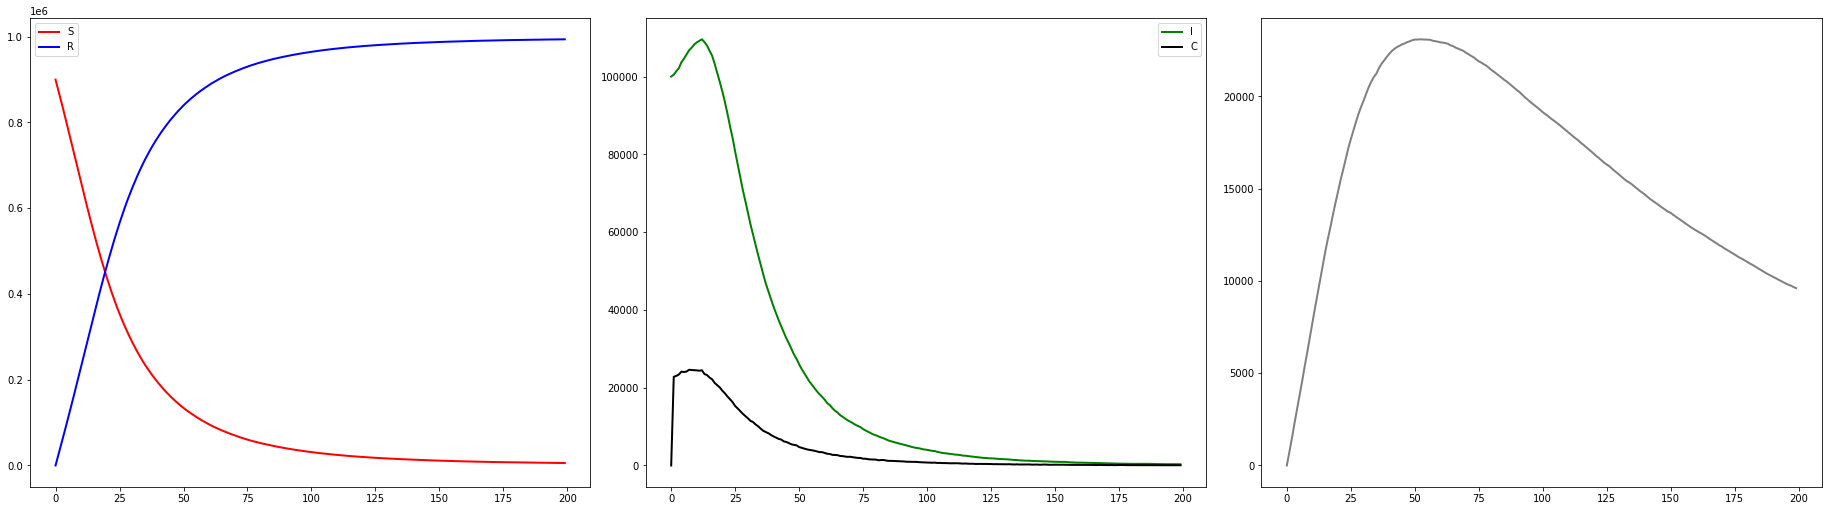

In [72]:

fig, ax = plt.subplots(1, 3, figsize=(25.5, 7.2))
ax[0].plot(x_sol_df.index.values, x_sol_df["S"], lw=2, c="r", label="S")
ax[0].plot(x_sol_df.index.values, x_sol_df["R"], lw=2, c="b", label="R")

ax[1].plot(x_sol_df.index.values, x_sol_df["I"], lw=2, c="g", label="I")
ax[1].plot(x_sol_df.index.values, x_sol_df["C"], lw=2, c="k", label="C")

ax[2].plot(x_sol_df.index.values, x_sol_df["W"], lw=2, c="gray", label="W")

ax[0].legend()
ax[1].legend()
plt.tight_layout()


In [92]:
beta_i_truth = 0.256
beta_w_truth = 1.21
zeta_truth   = 7.56e-3
N = 1e6


priors_range_dict  = {}
priors_range_dict["beta_i"] = [0.2, 0.3]    # Contact rate
priors_range_dict["beta_w"] = [1.1, 1.3]       # Environmental contact rate
priors_range_dict["zeta"]   = [1e-4, 1e-1] # Environmental Decay Rate

lambda_inf    = 1.1
num_params    = 3
num_iters_mif = 100
alpha_mif     = 0.9 # Variance shrinking factor
num_ensembles = 300
################################

obs_df    = x_sol_df[["C"]].rename(columns={"C": "confirmed"})

oev_df         = pd.DataFrame(columns=["date", "oev"])
oev_df["date"] = obs_df.index.values
oev_df         = oev_df.set_index("date")

oev_df["oev"] = np.maximum(5000,  1+(0.4*obs_df["confirmed"].values)**2  )

######## INFERENCE  SETTINGS ########
# Range of parameters
param_range = np.array([v for k, v in priors_range_dict.items()])
std_param   = param_range[:,1]-param_range[:,0]
SIG         = std_param ** 2 / 4; #  initial covariance of parameters

num_steps     = len(obs_df) #387
para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
theta         = np.zeros((num_params, num_iters_mif+1))

confirmed_post_all = np.zeros((1, num_ensembles, num_steps, num_iters_mif))
deaths_post_all   = np.zeros((1, num_ensembles, num_steps, num_iters_mif))

para_post_all = np.zeros((num_params, num_ensembles, num_steps, num_iters_mif))
x_post_all    = np.zeros((5, num_ensembles, num_steps, num_iters_mif))
theta         = np.zeros((num_params, num_iters_mif+1))

dates_assimilation = obs_df.index.get_level_values(0).values
dates = dates_assimilation

################################################

In [93]:
from tqdm import tqdm

print(f"Running MIF  \n")
for n in tqdm(range(num_iters_mif)):
    if n==0:
        p_prior     = sample_params_uniform(priors_range_dict, num_ensembles=num_ensembles)
        beta_i          = p_prior[0,:]
        beta_w          = p_prior[1,:]
        zeta            = p_prior[2,:]
        x               = np.array([ [N-0.1*N, 0.1*N, 0, 0, 0] ]).T * np.ones((5, num_ensembles))
        theta[:, n] = np.mean(p_prior, -1)

    else:
        params_mean     = theta[:,n]
        params_var      = SIG * (alpha_mif**n)**2
        p_prior         = sample_params_normal(priors_range_dict, params_mean, params_var, num_ensembles=num_ensembles)
        beta_i          = p_prior[0,:]
        beta_w          = p_prior[1,:]
        zeta            = p_prior[2,:]
        x               = np.array([ [N-0.1*N, 0.1*N, 0, 0, 0] ]).T * np.ones((5, num_ensembles))

    param_post_time   = np.zeros((len(priors_range_dict), num_ensembles, num_steps))
    x_post_time       = np.zeros((5, num_ensembles, num_steps))

    cases_post_time   = np.zeros((1, num_ensembles, num_steps))
    deaths_post_time  = np.zeros((1, num_ensembles, num_steps))

    idx_date_update = 0


    cases_t = np.zeros((num_ensembles, 1))
    deaths_t = np.zeros((num_ensembles, 1))

    confirmed_t = np.zeros((num_ensembles, 1))
    deaths_t    = np.zeros((num_ensembles, 1))

    for idx_t, date in enumerate(dates):

        #infalte state variables
        x = inflate_ensembles(x, inflation_value=lambda_inf, num_ensembles=300)
        x = checkbound_state_vars(x_state_ens=x, pop=N, num_params=x.shape[0], num_ensembles=300)

        #inflate parameters
        p_prior = inflate_ensembles(p_prior, inflation_value=lambda_inf)
        p_prior = checkbound_params(priors_range_dict, p_prior, num_ensembles=300)

        x_ens =[]
        for idx_ens in range(num_ensembles):
            beta_i          = p_prior[0,idx_ens]
            beta_w          = p_prior[1,idx_ens]
            zeta            = p_prior[2,idx_ens]

            x_ens.append(model(x[:,idx_ens], beta_i, beta_w, zeta, N))

        x_ens = np.array(x_ens).T
        x = x_ens

        confirmed_t  +=  np.expand_dims(x[-1,:], -1)

        if pd.to_datetime(date) == pd.to_datetime(dates_assimilation[idx_date_update]):

                oev_confirmed_time = oev_df.loc[date]["oev"]

                confirmed_time = obs_df.loc[date]["confirmed"]

                param_post = p_prior.copy()
                # Update parameters using confirmed deaths
                x_post, param_post, confirmed_obs_post = eakf_step(x, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, priors_range_dict, num_var=5)
                x_post                                 = checkbound_state_vars(x_state_ens=x_post, pop=N, num_params=x.shape[0], num_ensembles=300)
                param_post                             = checkbound_params(priors_range_dict, params_ens=param_post, num_ensembles=300)

                x = x_post
                # Use posterior and next prior
                p_prior = param_post.copy()

                cases_post_time[:,:,idx_date_update]  = confirmed_obs_post
                param_post_time[:,:,idx_date_update]  = param_post
                x_post_time[:,:,idx_date_update]      = x_post

                idx_date_update += 1

                confirmed_t = np.zeros((num_ensembles, 1))

    confirmed_post_all[:,:,:,n] = cases_post_time
    para_post_all[:,:,:,n]      = param_post_time
    x_post_all[:,:,:,n]         = x_post_time
    theta[:,n+1]                = param_post_time.mean(-1).mean(-1)


  0%|          | 0/100 [00:00<?, ?it/s]

Running MIF  



100%|██████████| 100/100 [03:59<00:00,  2.39s/it]


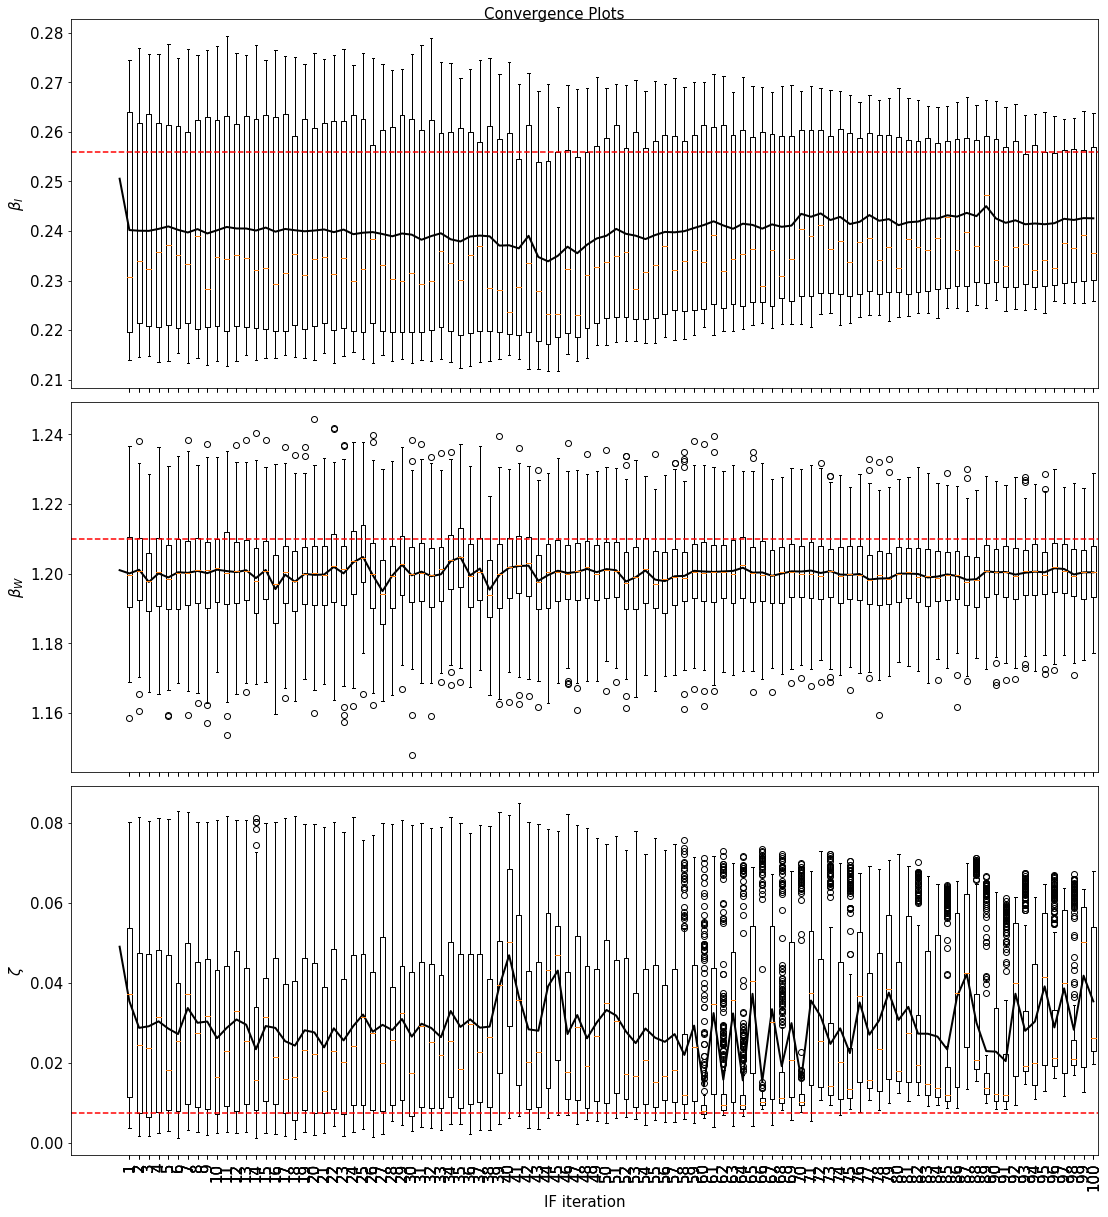

In [94]:

para_post_iter = para_post_all.mean(2)
import seaborn as sns
# Convergence Plots
fig, ax = plt.subplots(3, 1, figsize=(15.5, 17.2), sharex=True)
ax[0].boxplot(para_post_iter[0,:,:])
ax[0].plot(range(num_iters_mif+1), theta[0,:], color="k", lw=2)
ax[0].axhline(y=beta_i_truth, color="red", linestyle="--")

ax[1].boxplot(para_post_iter[1, :, :])
ax[1].plot(range(num_iters_mif+1), theta[1,:], color="k", lw=2)
ax[1].axhline(y=beta_w_truth, color="red", linestyle="--")

ax[2].boxplot(para_post_iter[2, :, :])
ax[2].plot(range(num_iters_mif+1), theta[2,:], color="k", lw=2)
ax[2].axhline(y=zeta_truth, color="red", linestyle="--")

ax[0].set_ylabel(r"$\beta_I$", fontsize=15)
ax[1].set_ylabel(r"$\beta_W$", fontsize=15)
ax[2].set_ylabel(r"$\zeta$", fontsize=15)

for axi in ax:
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)

ax[2].set_xlabel("IF iteration", fontsize=15)
fig.suptitle("Convergence Plots", fontsize=15)
plt.tight_layout()

In [95]:
#### Plot fit with default parameters ####
# Data


times  = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 147, 154, 161]
cases  = [113, 60, 75, 148, 379, 2911, 4572, 5361, 5300, 6348, 5346, 4412, 3558, 2271, 1931, 2251, 1692, 1184, 816, 748, 770, 522, 553, 379]
